Names: Fabio Lenherr & Kaj Habegger

## Import required libraries

In [ ]:
! pip install tensorflow
! pip install matplotlib
! pip install scikit-learn

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
import tensorflow.keras as keras
import keras.layers as layers
from sklearn.model_selection import KFold 

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Sklearn for Confusion Matrix
from sklearn.metrics import confusion_matrix

print(tf.__version__)

2.10.1


In [2]:
# Check whether GPU is available for ML or not
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Set Parameters

In [3]:
train_dir = 'datasets/dataset_training/'
test_dir = 'datasets/dataset_testing/'
batch_size = 32
img_height = 64
img_width = 64
num_epochs = 40

## Define usable functions

In [4]:
def plt_confmatrix(y_preds, y_trues, class_names):
    conf_matrix = confusion_matrix(y_trues, y_preds, labels=class_names)
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.matshow(conf_matrix)

    ax.xaxis.set_major_locator(ticker.FixedLocator(range(-1, len(class_names))))
    ax.yaxis.set_major_locator(ticker.FixedLocator(range(-1, len(class_names))))
    ax.set_xticklabels([''] + class_names)
    ax.set_yticklabels([''] + class_names)

    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i, s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
        
    plt.xlabel('Predictions')
    plt.ylabel('Actuals')
    plt.title('Confusion Matrix')
    plt.show()

## Load data

In [5]:
training_ds, validation_ds = keras.utils.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(img_height, img_width), # Some preprocessing happening here, resizing the images
    subset="both",
    seed=42,
    validation_split=0.2
)


testing_ds = keras.utils.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(img_height, img_width) # Some preprocessing happening here, resizing the images
)

class_names = training_ds.class_names
num_classes = len(training_ds.class_names)

Found 16276 files belonging to 11 classes.
Using 13021 files for training.
Using 3255 files for validation.
Found 9979 files belonging to 11 classes.


## Configure the dataset for performance

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

training_ds = training_ds.cache().prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)
testing_ds = testing_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Dataset.cache keeps the images in memory after they're loaded off disk during the first epoch.
# This will ensure the dataset does not become a bottleneck while training your model.
# If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

# Dataset.prefetch overlaps data preprocessing and model execution while training

## Data information and visualization

In [7]:
print(class_names)

['bug', 'electric', 'fire', 'fly', 'grass', 'ground', 'normal', 'poison', 'psychic', 'rock', 'water']


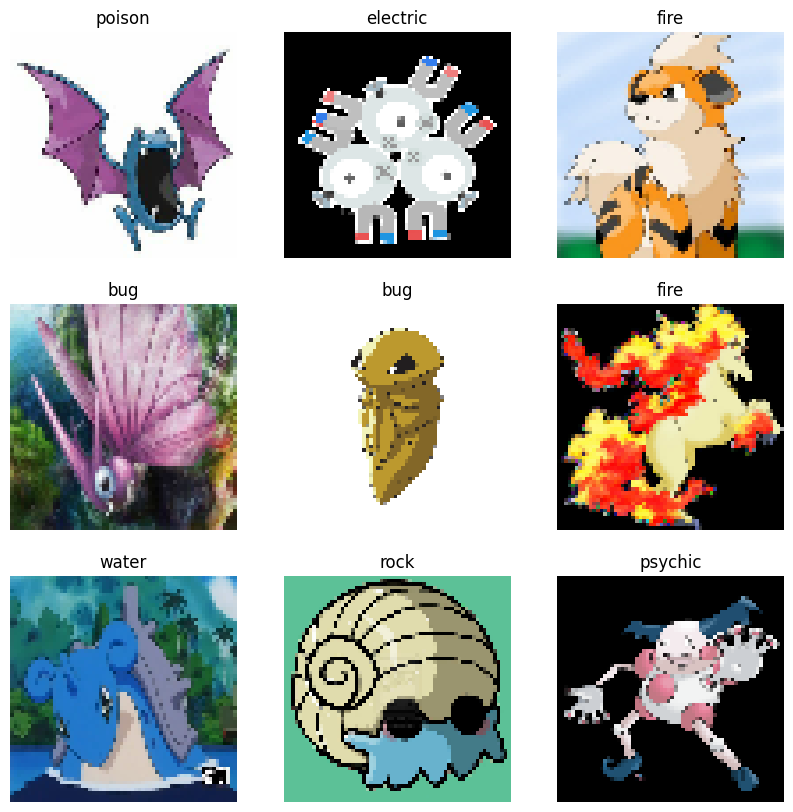

In [8]:
plt.figure(figsize=(10, 10))
for images, labels in training_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [9]:
# Shape of each Batch
for image_batch, labels_batch in training_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 64, 64, 3)
(32,)


## Underfitted Model

In [103]:
underfitted_model = keras.Sequential([
    layers.Rescaling(1./63), # Some preprocessing happening here, normalizing the data
    layers.Conv2D(1, 30, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(num_classes, activation='softmax')
])

In [104]:
underfitted_model.compile(
    optimizer='adam',
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['acc']
)

In [105]:
underfitted_history = underfitted_model.fit(
    training_ds,
    validation_data=validation_ds,
    epochs=num_epochs,
    use_multiprocessing=True
)

Epoch 1/40
407/407 [==============================] - 1s 3ms/step - loss: 2.3706 - acc: 0.2129 - val_loss: 2.3375 - val_acc: 0.2071
Epoch 2/40
407/407 [==============================] - 1s 3ms/step - loss: 2.3170 - acc: 0.2143 - val_loss: 2.3120 - val_acc: 0.2071
Epoch 3/40
407/407 [==============================] - 1s 3ms/step - loss: 2.2987 - acc: 0.2143 - val_loss: 2.3036 - val_acc: 0.2071
Epoch 4/40
407/407 [==============================] - 1s 3ms/step - loss: 2.2924 - acc: 0.2143 - val_loss: 2.3014 - val_acc: 0.2071
Epoch 5/40
407/407 [==============================] - 1s 3ms/step - loss: 2.2905 - acc: 0.2143 - val_loss: 2.3011 - val_acc: 0.2071
Epoch 6/40
407/407 [==============================] - 1s 3ms/step - loss: 2.2899 - acc: 0.2143 - val_loss: 2.3011 - val_acc: 0.2071
Epoch 7/40
407/407 [==============================] - 1s 3ms/step - loss: 2.2896 - acc: 0.2143 - val_loss: 2.3011 - val_acc: 0.2071
Epoch 8/40
407/407 [==============================] - 1s 3ms/step - loss: 2.

In [106]:
underfitted_model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_23 (Rescaling)    (None, 64, 64, 3)         0         
                                                                 
 conv2d_45 (Conv2D)          (None, 35, 35, 1)         2701      
                                                                 
 max_pooling2d_44 (MaxPoolin  (None, 17, 17, 1)        0         
 g2D)                                                            
                                                                 
 flatten_22 (Flatten)        (None, 289)               0         
                                                                 
 dense_23 (Dense)            (None, 11)                3190      
                                                                 
Total params: 5,891
Trainable params: 5,891
Non-trainable params: 0
___________________________________________________

In [107]:
acc = underfitted_history.history['acc']
val_acc = underfitted_history.history['val_acc']
loss = underfitted_history.history['loss']
val_loss = underfitted_history.history['val_loss']

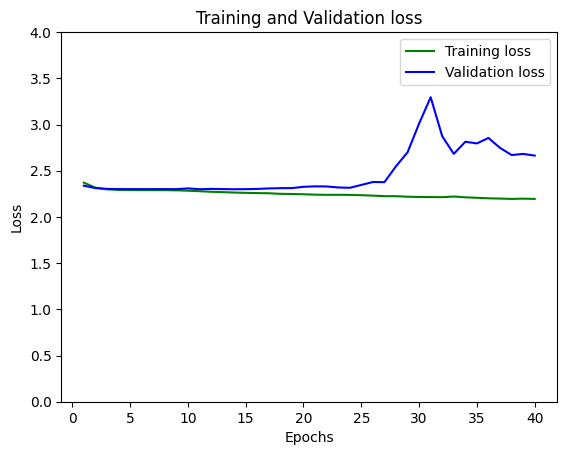

In [108]:
# Plotting training and validation loss
epochs = range(1,num_epochs+1)
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim([0, 4])
plt.legend()
plt.show()

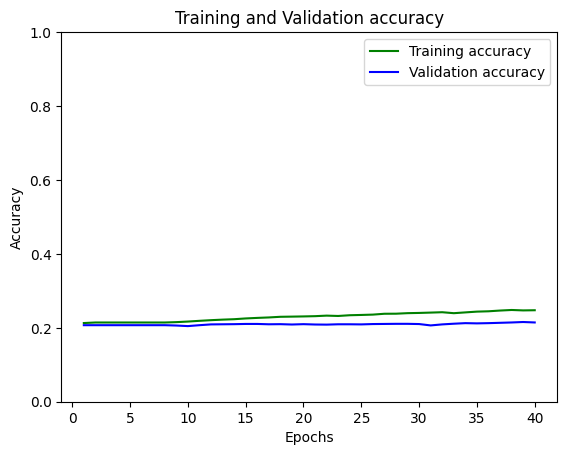

In [109]:
# Plotting training and validation accuracy
plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [110]:
preds = np.empty((0, 2), dtype=int)
for images, labels in iter(testing_ds):
    pred = underfitted_model.predict(images.numpy().astype("uint8"))
    for i in range(len(pred)):
        y_pred = np.argmax(pred[i])
        preds = np.append(preds, [[class_names[labels[i]], class_names[y_pred]]], axis=0)
        
y_preds = preds[:, 1]
y_trues = preds[:, 0]

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 38ms/step


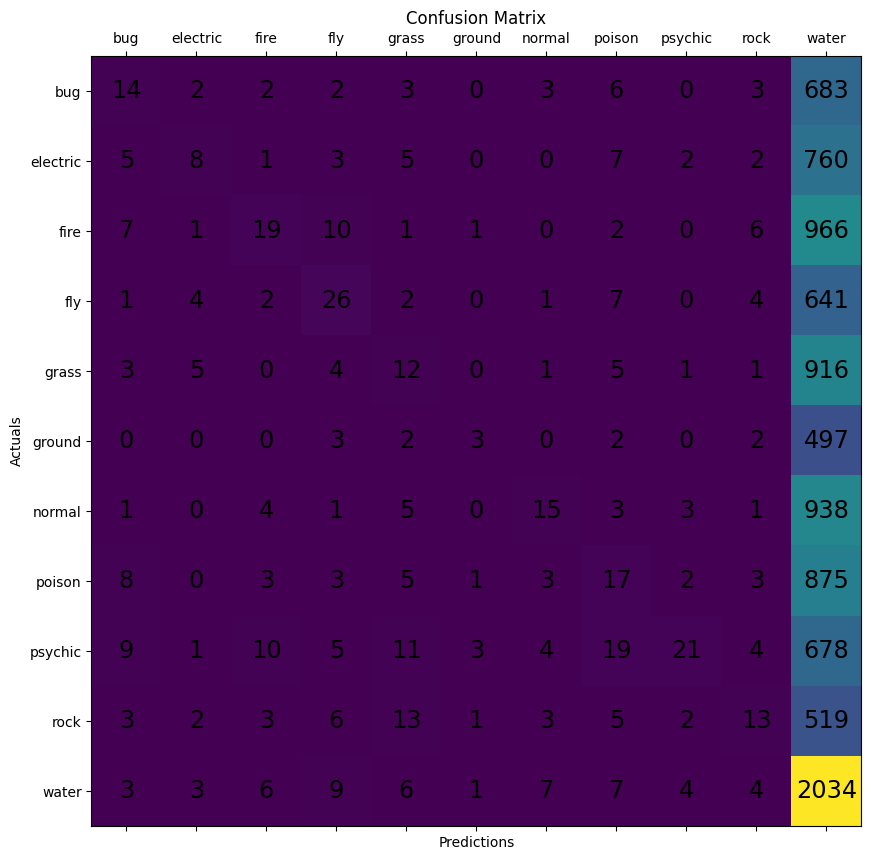

In [111]:
plt_confmatrix(y_preds, y_trues, class_names)

### Discussion
Water gets most often predicted. That's because our dataset has a higher amount of water typed pokemons. But as we can see the model is still underfitting as obviously nothing/not enough is learned from the data.

## Overfitted Model

In [10]:
overfitted_model = keras.Sequential([
        layers.Rescaling(1./63), # Some preprocessing happening here, normalizing the data
        layers.Conv2D(64, 2, activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(128, 2, activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(256, 2, activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(500),
        layers.Dense(11, activation='softmax') # Amount of neurons risen to achieve ovrfitting
])

In [11]:
overfitted_model.compile(
    optimizer='adam', 
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['acc']
)

In [12]:
overfitted_history = overfitted_model.fit(
    training_ds,
    validation_data=validation_ds,
    epochs=num_epochs,
    use_multiprocessing=True
)

Epoch 1/40
407/407 [==============================] - 24s 50ms/step - loss: 1.8829 - acc: 0.4287 - val_loss: 1.4478 - val_acc: 0.5171
Epoch 2/40
407/407 [==============================] - 2s 6ms/step - loss: 1.3201 - acc: 0.5718 - val_loss: 1.3702 - val_acc: 0.5579
Epoch 3/40
407/407 [==============================] - 2s 6ms/step - loss: 1.1137 - acc: 0.6364 - val_loss: 1.2444 - val_acc: 0.6037
Epoch 4/40
407/407 [==============================] - 2s 6ms/step - loss: 0.9488 - acc: 0.6913 - val_loss: 1.2729 - val_acc: 0.6123
Epoch 5/40
407/407 [==============================] - 2s 6ms/step - loss: 0.8245 - acc: 0.7311 - val_loss: 1.2516 - val_acc: 0.6415
Epoch 6/40
407/407 [==============================] - 2s 6ms/step - loss: 0.6715 - acc: 0.7758 - val_loss: 1.3526 - val_acc: 0.6559
Epoch 7/40
407/407 [==============================] - 2s 6ms/step - loss: 0.5821 - acc: 0.8086 - val_loss: 1.4717 - val_acc: 0.6436
Epoch 8/40
407/407 [==============================] - 2s 6ms/step - loss: 

In [13]:
overfitted_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 64, 64, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 63, 63, 64)        832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 128)       32896     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 15, 15, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 256)       1

In [114]:
acc = overfitted_history.history['acc']
val_acc = overfitted_history.history['val_acc']
loss = overfitted_history.history['loss']
val_loss = overfitted_history.history['val_loss']

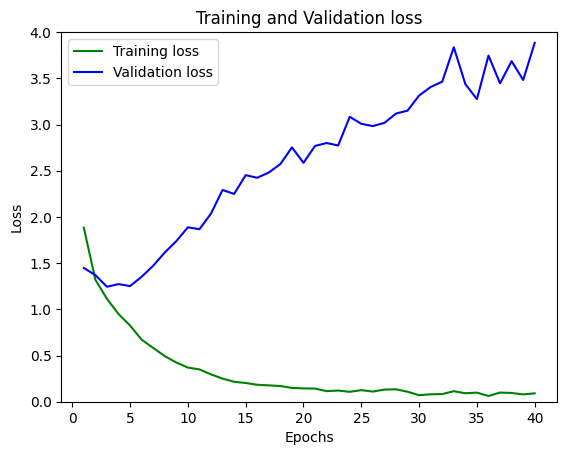

In [115]:
# Plotting training and validation loss
epochs = range(1,num_epochs+1)
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim([0, 4])
plt.legend()
plt.show()

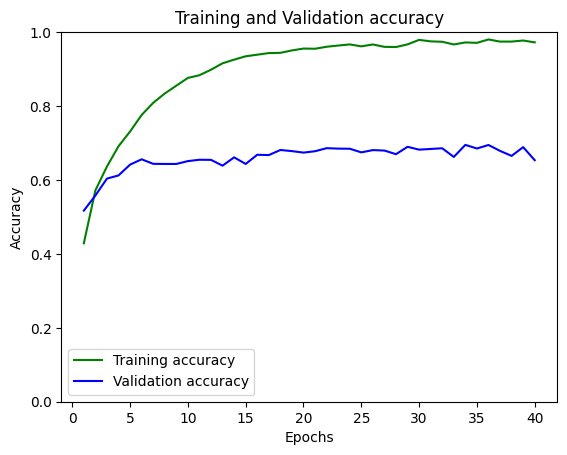

In [116]:
# Plotting training and validation accuracy
plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [17]:
preds = np.empty((0, 2), dtype=int)
for images, labels in iter(testing_ds):
    pred = overfitted_model.predict(images.numpy().astype("uint8"))
    for i in range(len(pred)):
        y_pred = np.argmax(pred[i])
        preds = np.append(preds, [[class_names[labels[i]], class_names[y_pred]]], axis=0)
        
y_preds = preds[:, 1]
y_trues = preds[:, 0]

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 224ms/step


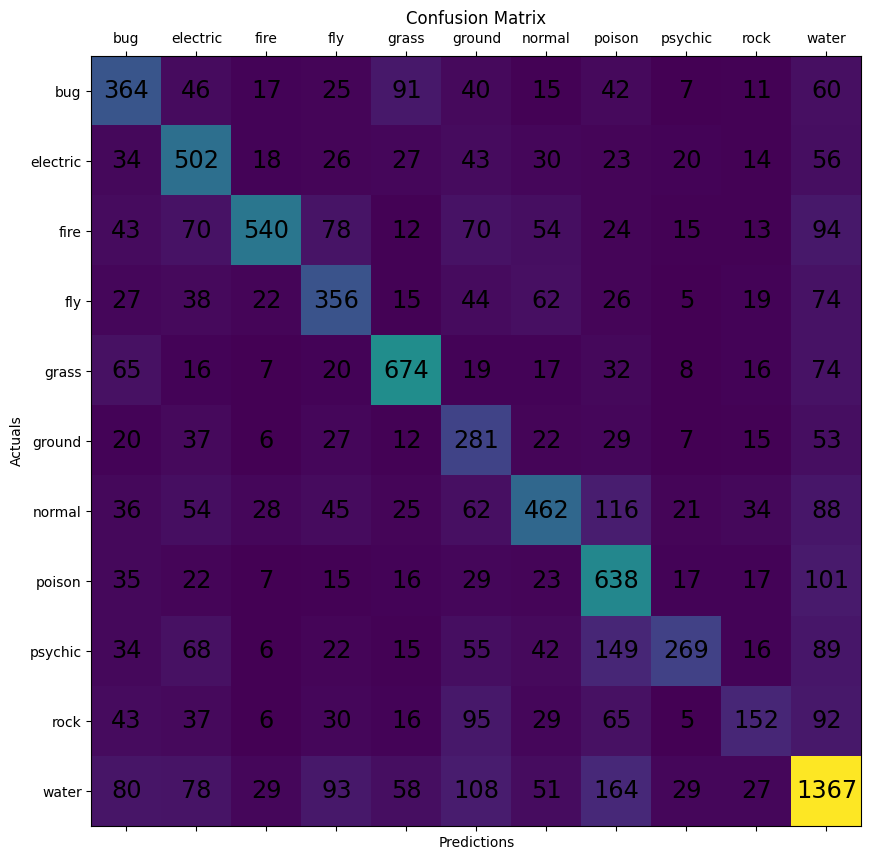

In [18]:
plt_confmatrix(y_preds, y_trues, class_names)

## Optimized Model

### Discussion
In here we will use kfold cross validation to ensure that our model is not overffitting or underfitting, the expectation therefore is a good score in both train/validation accuracy as well as test accuracy. Reload data without the datasplit, as kfold cross validation takes care of this instead!

### Kfold params & Regularizer

In [29]:
splits = 5
scores = [None] * splits
models = [None] * splits
regularizer = keras.regularizers.l2(0.01)

### Setup for Kfold

In [30]:
train_images = np.concatenate(list(training_ds.map(lambda x, y:x)))
train_labels = np.concatenate(list(training_ds.map(lambda x, y:y)))

val_images = np.concatenate(list(validation_ds.map(lambda x, y:x)))
val_labels = np.concatenate(list(validation_ds.map(lambda x, y:y)))

inputs = np.concatenate((train_images, val_images), axis=0)
targets = np.concatenate((train_labels, val_labels), axis=0)


kfold = KFold(n_splits=splits, shuffle=True)
iteration = 0
print("kfold setup done")

kfold setup done


### KFold

In [31]:
print("Starting kfold model evaluation")
for train, test in kfold.split(inputs, targets):
    optimized_model = keras.Sequential([
        layers.Rescaling(1./63), # Some preprocessing happening here, normalizing the data
        layers.Conv2D(64, 5, activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(128, 5, activation='relu', kernel_regularizer=regularizer),
        layers.MaxPooling2D(),
        layers.Conv2D(256, 5, activation='relu', kernel_regularizer=regularizer),
        layers.Dropout(0.5),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    print("fitting model: " + f"{iteration}")
    
    optimized_model.compile(
        optimizer='adam', 
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['acc']
    )
    
    optimized_history = optimized_model.fit(
        inputs[train],
        targets[train],
        validation_data=validation_ds,
        epochs=20
    )
    
    models[iteration] = optimized_model
    
    scores[iteration] = optimized_model.evaluate(inputs[test], targets[test], verbose=0)
    iteration += 1

print(scores)

Starting kfold model evaluation
fitting model: 0
Epoch 1/20
407/407 [==============================] - 3s 6ms/step - loss: 2.2006 - acc: 0.4043 - val_loss: 1.6045 - val_acc: 0.5124
Epoch 2/20
407/407 [==============================] - 2s 6ms/step - loss: 1.5376 - acc: 0.5295 - val_loss: 1.3865 - val_acc: 0.5862
Epoch 3/20
407/407 [==============================] - 2s 6ms/step - loss: 1.3685 - acc: 0.5846 - val_loss: 1.3027 - val_acc: 0.6172
Epoch 4/20
407/407 [==============================] - 2s 6ms/step - loss: 1.2523 - acc: 0.6298 - val_loss: 1.1977 - val_acc: 0.6716
Epoch 5/20
407/407 [==============================] - 2s 6ms/step - loss: 1.1794 - acc: 0.6580 - val_loss: 1.0970 - val_acc: 0.6962
Epoch 6/20
407/407 [==============================] - 2s 6ms/step - loss: 1.1039 - acc: 0.6849 - val_loss: 1.0249 - val_acc: 0.7164
Epoch 7/20
407/407 [==============================] - 2s 6ms/step - loss: 1.0550 - acc: 0.7025 - val_loss: 1.0104 - val_acc: 0.7266
Epoch 8/20
407/407 [=======

407/407 [==============================] - 2s 6ms/step - loss: 1.5448 - acc: 0.5260 - val_loss: 1.4741 - val_acc: 0.5475
Epoch 3/20
407/407 [==============================] - 2s 6ms/step - loss: 1.3638 - acc: 0.5863 - val_loss: 1.3100 - val_acc: 0.6230
Epoch 4/20
407/407 [==============================] - 2s 6ms/step - loss: 1.2312 - acc: 0.6395 - val_loss: 1.2026 - val_acc: 0.6513
Epoch 5/20
407/407 [==============================] - 2s 6ms/step - loss: 1.1398 - acc: 0.6689 - val_loss: 1.0993 - val_acc: 0.6937
Epoch 6/20
407/407 [==============================] - 2s 6ms/step - loss: 1.0590 - acc: 0.7005 - val_loss: 1.0404 - val_acc: 0.7115
Epoch 7/20
407/407 [==============================] - 2s 6ms/step - loss: 1.0036 - acc: 0.7210 - val_loss: 0.9817 - val_acc: 0.7364
Epoch 8/20
407/407 [==============================] - 2s 6ms/step - loss: 0.9631 - acc: 0.7363 - val_loss: 0.9360 - val_acc: 0.7613
Epoch 9/20
407/407 [==============================] - 2s 6ms/step - loss: 0.9134 - acc:

### Retrain the best model with all data and use this as the optimized model

In [32]:
best_model_score = 0 
best_model = 0
iteration = 0

for selected_model in scores: 
    if selected_model[1] > best_model_score:
        best_model_score = selected_model[1]
        best_model = iteration 
    iteration += 1

optimized_model = models[best_model]

optimized_history = optimized_model.fit(
    training_ds,
    validation_data=validation_ds,
    epochs=num_epochs
)

Epoch 1/40
407/407 [==============================] - 2s 6ms/step - loss: 0.7102 - acc: 0.8351 - val_loss: 0.7052 - val_acc: 0.8347
Epoch 2/40
407/407 [==============================] - 2s 5ms/step - loss: 0.6569 - acc: 0.8492 - val_loss: 0.7142 - val_acc: 0.8286
Epoch 3/40
407/407 [==============================] - 2s 6ms/step - loss: 0.6305 - acc: 0.8550 - val_loss: 0.7441 - val_acc: 0.8221
Epoch 4/40
407/407 [==============================] - 2s 6ms/step - loss: 0.5905 - acc: 0.8703 - val_loss: 0.7786 - val_acc: 0.8117
Epoch 5/40
407/407 [==============================] - 2s 6ms/step - loss: 0.5905 - acc: 0.8689 - val_loss: 0.7892 - val_acc: 0.8089
Epoch 6/40
407/407 [==============================] - 2s 6ms/step - loss: 0.5760 - acc: 0.8751 - val_loss: 0.8335 - val_acc: 0.7939
Epoch 7/40
407/407 [==============================] - 2s 5ms/step - loss: 0.5560 - acc: 0.8781 - val_loss: 0.8843 - val_acc: 0.7877
Epoch 8/40
407/407 [==============================] - 2s 6ms/step - loss: 0.

In [33]:
optimized_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_8 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_24 (Conv2D)          (None, 62, 62, 64)        1792      
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 31, 31, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 29, 29, 128)       73856     
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 14, 14, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 12, 12, 256)      

In [117]:
acc = optimized_history.history['acc']
val_acc = optimized_history.history['val_acc']
loss = optimized_history.history['loss']
val_loss = optimized_history.history['val_loss']

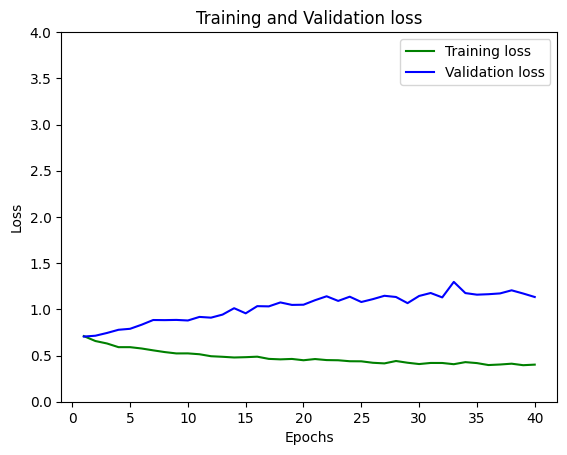

In [118]:
# Plotting training and validation loss
epochs = range(1,num_epochs+1)
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim([0, 4])
plt.legend()
plt.show()

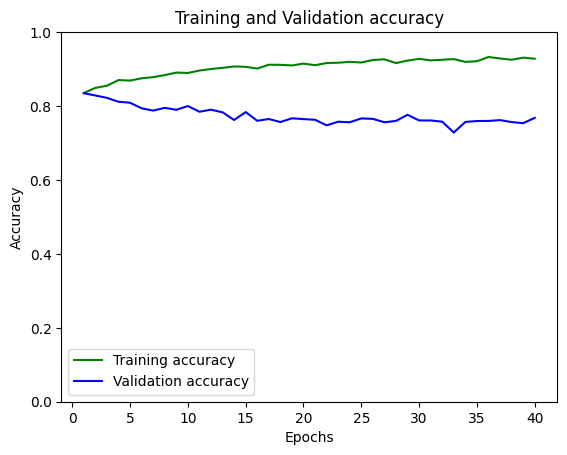

In [119]:
# Plotting training and validation accuracy
plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [37]:
preds = np.empty((0, 2), dtype=int)
for images, labels in iter(testing_ds):
    pred = optimized_model.predict(images.numpy().astype("uint8"))
    for i in range(len(pred)):
        y_pred = np.argmax(pred[i])
        preds = np.append(preds, [[class_names[labels[i]], class_names[y_pred]]], axis=0)
        
y_preds = preds[:, 1]
y_trues = preds[:, 0]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 45ms/step


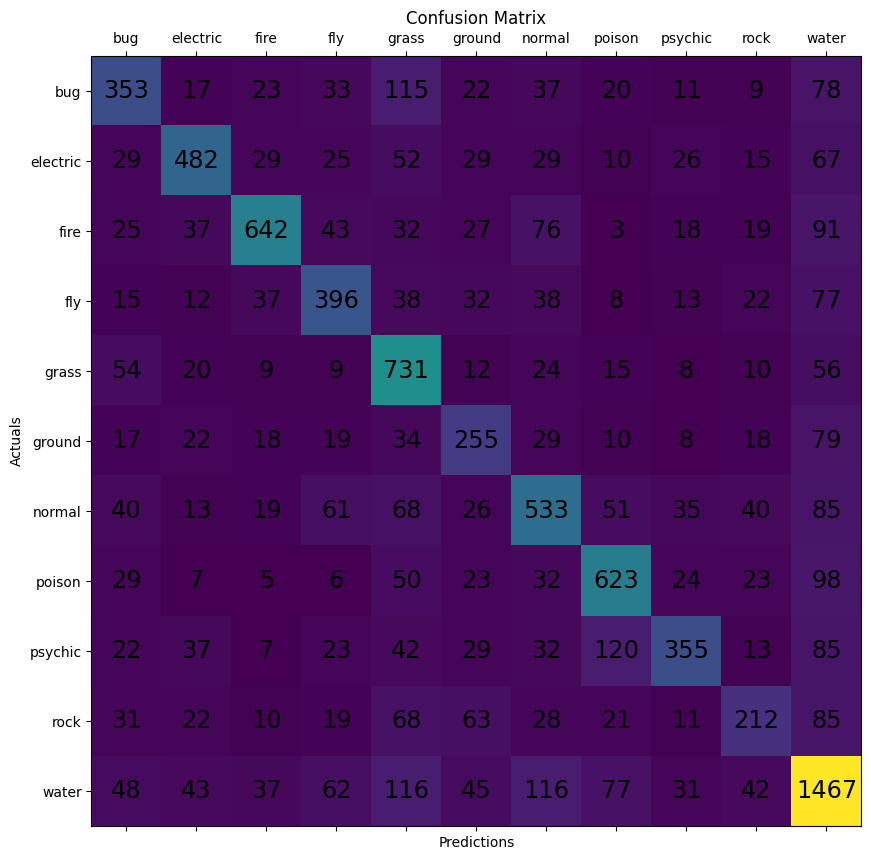

In [38]:
plt_confmatrix(y_preds, y_trues, class_names)

## Single Picture Prediction

### Discussion
To check the individual models simply change the name. We have left out individual predictions for each model to save space.

In [ ]:
probability_model = tf.keras.Sequential([optimized_model, 
                                         tf.keras.layers.Softmax()])

In [ ]:
predictions = probability_model.predict(testing_ds)

In [ ]:
predictions[0]

In [ ]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(11))
  plt.yticks([])
  thisplot = plt.bar(range(11), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

In [ ]:
i = 10
ds = testing_ds

plt.figure(figsize=(10, 10))
plt.subplot(1,2,1)
#for images, labels in test_ds.take(1):
iterator = iter(ds)
image, labels = next(iterator)
plot_image(i, predictions[i], labels, image)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  labels)
plt.show()